In [201]:
import inferelator_ng.prior as priors
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [202]:
base_dir='/Users/ndeveaux/Dropbox (Simons Foundation)/atac_parameter_search/ChipSeq/chipseq_priors/chipseq_mm10_th17_prior_gen_2017_01/references'

In [203]:
macs_folders = ['2016_11_28_MACS_out', '2016_11_15_MACS_out']
references = ['tss_mm10.bed']

In [204]:
metadata_file = os.path.join(base_dir, 'metadata_ChIP.txt')
metadata = pd.read_csv(metadata_file, sep = '\t')

In [205]:
gene_bed = os.path.join(base_dir, 'tss_mm10.bed')
dists=[5000, 10000]

In [206]:
gene_df = pd.read_csv(gene_bed, sep = '\t', header=None)

In [207]:
computed_priors = {}

In [200]:
for row in metadata.iterrows():
    row_content = row[1]
    sample = ('_').join([row_content['sampleName'], row_content['compare2']])
    gene = row_content['gene']
    for mac in macs_folders:
        for dist in dists:
            motif_bed = os.path.join(os.path.join(os.path.join(base_dir, mac), sample), '_'.join([sample, 'peaks.bed']))
            p = Prior(motif_bed, gene_bed, regulators = [gene], targets = list(gene_df[3]), max_distance=dist, single_tf=True, mode='window')
            key = '_'.join([mac, str(dist), gene])
            if key not in computed_priors.keys():
                computed_priors[key] = {}
            computed_priors[key][sample] = p.make_prior()

AttributeError: 'module' object has no attribute 'keys'

In [164]:
combined_df = pd.DataFrame(priors['2016_11_15_MACS_out_SL3033_SL3036_5000_Batf']['Batf'])

In [165]:
combined_df['1000'] = priors['2016_11_15_MACS_out_SL3033_SL3036_10000_Batf']['Batf']

In [168]:
combined_df['10000-pval-10'] = priors['2016_11_28_MACS_out_SL3033_SL3036_10000_Batf']['Batf']

In [169]:
combined_df['5000-pval-10'] = priors['2016_11_28_MACS_out_SL3033_SL3036_5000_Batf']['Batf']

In [170]:
combined_df['5000-pval-5-sample-SL3037'] = priors['2016_11_15_MACS_out_SL3037_SL3036_5000_Batf']['Batf']

In [208]:
combined_df['5000-pval-5-combined'] = combined_df['5000-pval-5-sample-SL3037'] + combined_df['Batf']

In [210]:
max(combined_df['5000-pval-5-combined'] )

15

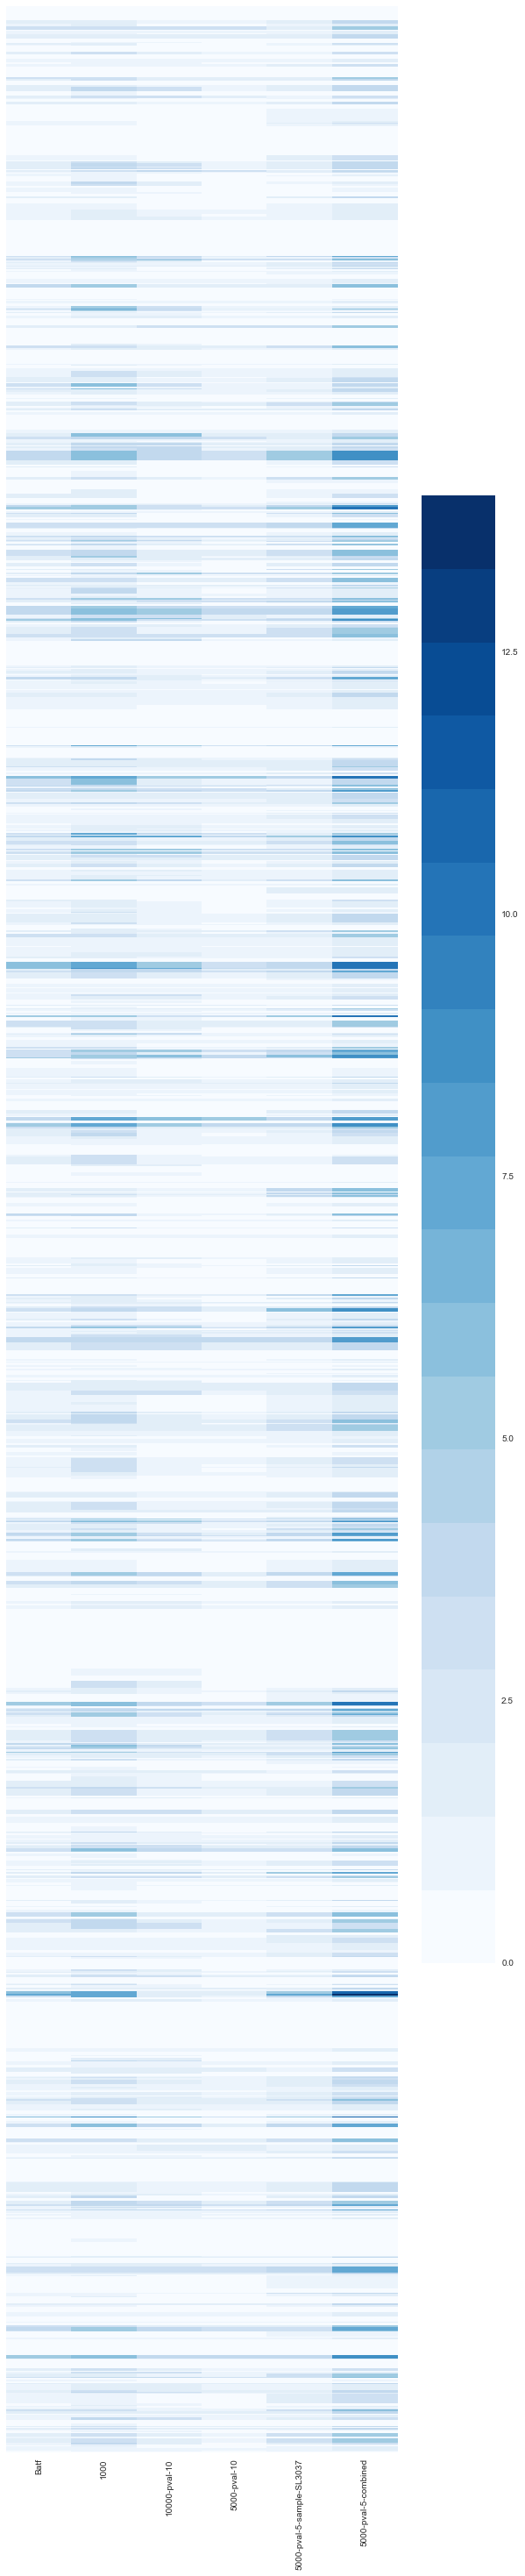

In [214]:
plt.figure(figsize=(10,50))
cmap = sns.light_palette('red', as_cmap=True)
sns.heatmap(combined_df.head(2000), annot=False, fmt="h", yticklabels=False,  cmap=plt.cm.get_cmap('Blues', 20))

In [101]:
# Sanity check: see if prior is what's expected, 7. 
max(priors['2016_11_15_MACS_out_SL1040_SL972']['Stat3'])

7

In [84]:
gene_df[gene_df[3] == 'uc011whu.1_up_1_chr1_4858327_f']

,0,1,2,3,4,5
18,chr1,4858326,4858327,uc011whu.1_up_1_chr1_4858327_f,0,+


In [110]:
new_prior = priors['2016_11_15_MACS_out_SL1040_SL972']
new_prior[new_prior['Stat3'] > 6]

,TF
uc057alc.1_up_1_chr8_35620774_f,7
uc009mmr.2_up_1_chr8_84662853_r,7
uc009nyw.2_up_1_chr8_126593437_r,7
uc011ybs.1_up_1_chr11_86584159_r,7


In [97]:
motif_bed='/Users/ndeveaux/Dropbox (Simons Foundation)/atac_parameter_search/ChipSeq/2016_11_22_performance_test_output/SL1040_SL972_peaks.bed'